In [5]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import tensorflow as tf

In [6]:
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'

train_data_dir = 'train_images/Train_Images/'
# TODO: Validation and test?

epochs = 8
batch_size = 50

In [7]:
# Load the pre-built VGG16 Model
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. /255)

2021-11-15 17:52:47.216559: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 0s 0us/step


In [9]:
# Create weights and features using VGG16

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
print("done")

Found 3002 images belonging to 3 classes.
done


In [10]:
# Create a bottleneck file

generator_top = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

train_data = np.load('bottleneck_features_train.npy')
train_labels = generator_top.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 3002 images belonging to 3 classes.


In [14]:
# Create a network

model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(75, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_labels, epochs=20, batch_size=batch_size, validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               2508900   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                3800      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                

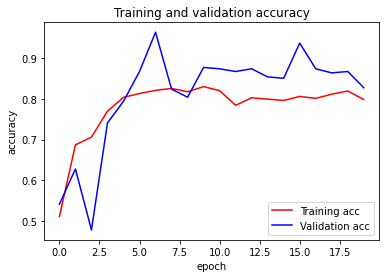

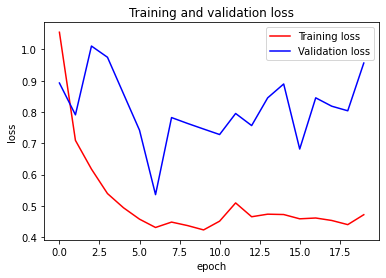

In [17]:
#Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()